In [1]:
!pip install geopandas contextily

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 73.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point, LineString

In [3]:
# Helper function to convert GPS coordinates to meters
def gps_to_meters(lat_diff, lon_diff, ref_lat):
    lat_meters = lat_diff * 111000  # 1 degree latitude ≈ 111 km
    lon_meters = lon_diff * (111000 * np.cos(np.radians(ref_lat)))  # 1 degree longitude ≈ 111 km * cos(latitude)
    return lat_meters, lon_meters

In [4]:
# Load and preprocess data
data = pd.read_csv('https://raw.githubusercontent.com/indhu68/Intro_to_DL_Project/main/Kasungu_Telemetry_Pts_Oct23.csv', parse_dates=['Time.Stamp'])
data = data[["Index", "Tag", "Latitude", "Longitude", "Time.Stamp"]]
data['Time.Stamp'] = pd.to_datetime(data['Time.Stamp'])
data.sort_values(by=['Tag', 'Time.Stamp'], inplace=True)
data['Time_diff'] = data['Time.Stamp'].diff().dt.total_seconds().fillna(0)
data['Lat_diff'] = data['Latitude'].diff().fillna(0)
data['Lon_diff'] = data['Longitude'].diff().fillna(0)


In [5]:

# Convert GPS differences to meters
data['Lat_meters'], data['Lon_meters'] = gps_to_meters(data['Lat_diff'], data['Lon_diff'], data['Latitude'].mean())

# Scale the latitude and longitude for the model
scaler = MinMaxScaler()
numeric_columns = ['Latitude', 'Longitude']
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

In [6]:

def create_sequences(data, n_input=200, n_output=20):
    X, y = [], []
    for i in range(n_input, len(data) - n_output + 1):
        X.append(data.iloc[i-n_input:i][numeric_columns].values)
        y.append(data.iloc[i:i+n_output][['Latitude', 'Longitude']].values.flatten())
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

X, y = create_sequences(data)


In [7]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [8]:

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, device='cuda'):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model, device=device)
        position = torch.arange(0, max_len, device=device).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2, device=device).float() * -(np.log(10000.0) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        return x + self.encoding[:, :x.size(1)]

# Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, output_dim, max_seq_length, device):
        super(TransformerModel, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_seq_length, device=device)
        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, batch_first=True)
        self.fc_out = nn.Linear(d_model, output_dim)

    def forward(self, src):
        src = self.embedding(src)
        src = self.pos_encoder(src)
        output = self.transformer(src, src)
        output = self.fc_out(output[:, -1, :])
        return output




In [9]:

# Hyperparameters and model initialization
input_dim = 2
d_model = 64
nhead = 4
num_encoder_layers = 3
num_decoder_layers = 3
dim_feedforward = 128
output_dim = 40  # Adjust based on  output sequence length and dimensions
max_seq_length = 200

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerModel(input_dim, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, output_dim, max_seq_length, device=device).to(device)

Epoch 1: Train Loss: 0.0019, Validation Loss: 0.0006, Train RMSE: 0.0440, Validation RMSE: 0.0252
Epoch 2: Train Loss: 0.0005, Validation Loss: 0.0005, Train RMSE: 0.0222, Validation RMSE: 0.0234
Epoch 3: Train Loss: 0.0004, Validation Loss: 0.0004, Train RMSE: 0.0209, Validation RMSE: 0.0209
Epoch 4: Train Loss: 0.0004, Validation Loss: 0.0004, Train RMSE: 0.0203, Validation RMSE: 0.0194
Epoch 5: Train Loss: 0.0004, Validation Loss: 0.0004, Train RMSE: 0.0198, Validation RMSE: 0.0193
Epoch 6: Train Loss: 0.0004, Validation Loss: 0.0004, Train RMSE: 0.0194, Validation RMSE: 0.0199
Epoch 7: Train Loss: 0.0004, Validation Loss: 0.0004, Train RMSE: 0.0191, Validation RMSE: 0.0191
Epoch 8: Train Loss: 0.0004, Validation Loss: 0.0003, Train RMSE: 0.0188, Validation RMSE: 0.0184
Epoch 9: Train Loss: 0.0003, Validation Loss: 0.0003, Train RMSE: 0.0185, Validation RMSE: 0.0184
Epoch 10: Train Loss: 0.0003, Validation Loss: 0.0003, Train RMSE: 0.0182, Validation RMSE: 0.0174
Epoch 11: Train Los

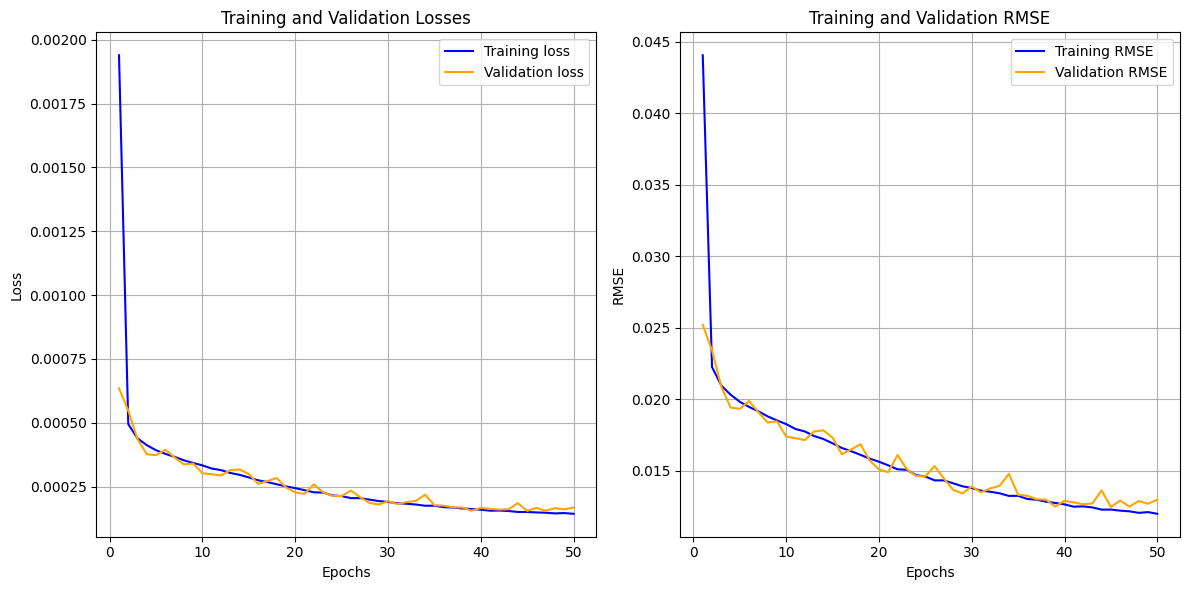

In [10]:

# defining training, validation, and plotting function
def train_validate_and_plot(model, train_loader, val_loader, num_epochs, device):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    train_rmses = []
    val_rmses = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        train_rmse = (avg_train_loss ** 0.5)
        val_rmse = (avg_val_loss ** 0.5)
        train_rmses.append(train_rmse)
        val_rmses.append(val_rmse)

        print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Train RMSE: {train_rmse:.4f}, Validation RMSE: {val_rmse:.4f}')
        if avg_val_loss < best_val_loss:
            torch.save(model.state_dict(), 'best_model.pth')
            best_val_loss = avg_val_loss

    # Plotting the results
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(12, 6))

    # Plotting losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training loss', color='blue')
    plt.plot(epochs, val_losses, label='Validation loss', color='orange')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    # Plotting RMSE
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_rmses, label='Training RMSE', color='blue')
    plt.plot(epochs, val_rmses, label='Validation RMSE', color='orange')
    plt.title('Training and Validation RMSE')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

#Train and validate the model
train_validate_and_plot(model, train_loader, test_loader, num_epochs=50, device=device)


In [11]:
torch.save(model.state_dict(), 'Transformer_seq20.pth')

In [12]:


def evaluate_model(model, test_loader, device, scaler):
    model.load_state_dict(torch.load('Transformer_seq20.pth')) #Load the model
    model.to(device)
    model.eval()

    all_past_data = []
    all_predictions = []
    all_actuals = []
    all_past_data_meters = []
    all_predictions_meters = []
    all_actuals_meters = []
    rmses = []
    rmses_meters = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            predictions = predictions.view(-1, 10, 2).cpu().numpy()
            actuals = y_batch.view(-1, 10, 2).cpu().numpy()
            past_data = X_batch[:, -100:, :2].view(-1, 100, 2).cpu().numpy()  # Assuming the last 200 points are relevant

            # Inverse transform to original scale
            predictions = scaler.inverse_transform(predictions.reshape(-1, 2)).reshape(-1, 10, 2)
            actuals = scaler.inverse_transform(actuals.reshape(-1, 2)).reshape(-1, 10, 2)
            past_data = scaler.inverse_transform(past_data.reshape(-1, 2)).reshape(-1, 100, 2)

            # Convert to meters

            ref_lat = actuals[0, 0, 0]
            predictions_meters = np.array([gps_to_meters(pred[:, 0], pred[:, 1], ref_lat) for pred in predictions])
            actuals_meters = np.array([gps_to_meters(act[:, 0], act[:, 1], ref_lat) for act in actuals])
            past_data_meters = np.array([gps_to_meters(past[:, 0], past[:, 1], ref_lat) for past in past_data])

            all_past_data.append(past_data)
            all_predictions.append(predictions)
            all_actuals.append(actuals)
            all_past_data_meters.append(past_data_meters)
            all_predictions_meters.append(np.array(predictions_meters))
            all_actuals_meters.append(np.array(actuals_meters))

            # Calculate RMSE for this batch and append
            batch_rmse = np.sqrt(mean_squared_error(predictions.reshape(-1, 2), actuals.reshape(-1, 2)))
            rmses.append(batch_rmse)




    average_rmse = np.mean(rmses)

    return all_past_data, all_actuals, all_predictions, all_past_data_meters, all_actuals_meters, all_predictions_meters, rmses, rmses_meters, average_rmse


all_past_data, all_actuals, all_predictions, all_past_data_meters, all_actuals_meters, all_predictions_meters, rmses, rmses_meters, average_rmse = evaluate_model(model, test_loader, device='cuda', scaler=scaler)
print("Average RMSE:", average_rmse)




Average RMSE: 0.016005097


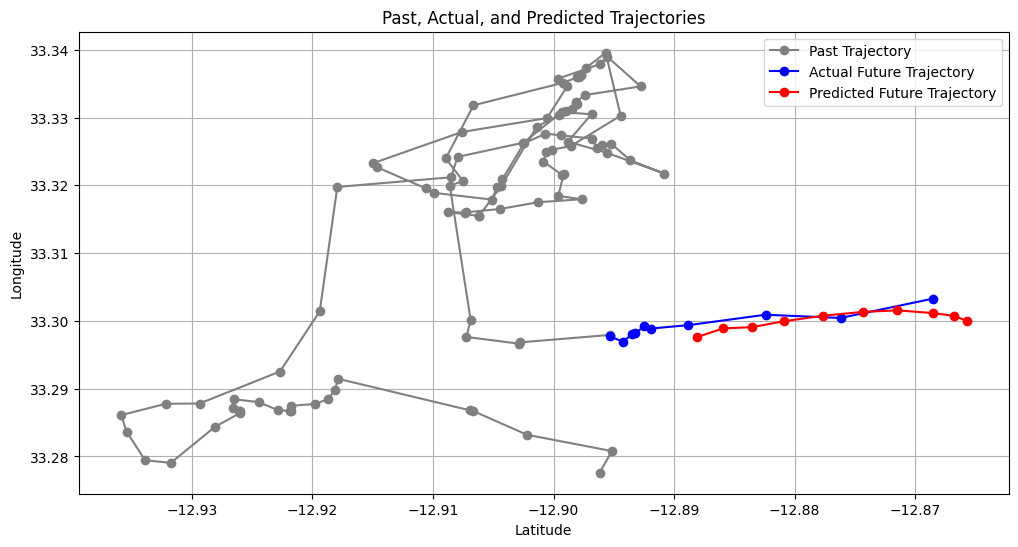

In [13]:
def plot_trajectories(past_data, actuals, predictions, index=0):
    plt.figure(figsize=(12, 6))
    # Plot the past trajectory
    plt.plot(past_data[index][0][:, 0], past_data[index][0][:, 1], 'gray', label='Past Trajectory', marker='o')
    # Plot the actual future trajectory
    plt.plot(actuals[index][0][:, 0], actuals[index][0][:, 1], 'bo-', label='Actual Future Trajectory')
    # Plot the predicted future trajectory
    plt.plot(predictions[index][0][:, 0], predictions[index][0][:, 1], 'ro-', label='Predicted Future Trajectory')

    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.title('Past, Actual, and Predicted Trajectories')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_trajectories(all_past_data, all_actuals, all_predictions, index=0)



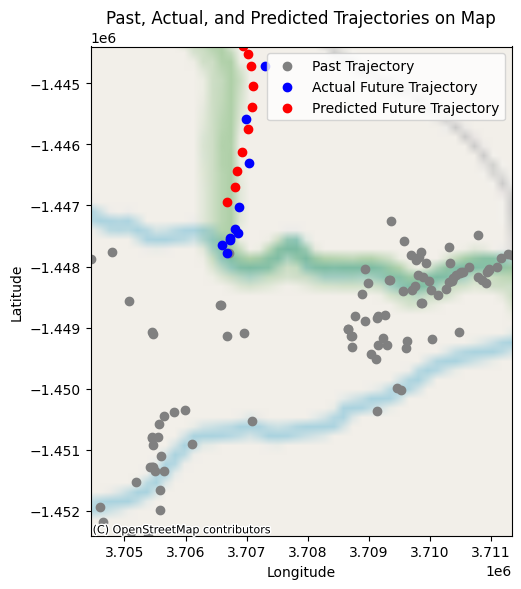

In [14]:
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Convert trajectories to GeoDataFrames
def to_geodataframe_trajectory(trajectory, crs="EPSG:4326"):
    geometry = [Point(xy) for xy in zip(trajectory[:, 1], trajectory[:, 0])]
    return gpd.GeoDataFrame(geometry=geometry, crs=crs)

# Plot trajectories on a map with higher zoom level and labels
def plot_trajectories_on_map(past_data, actuals, predictions, index=0):
    # Convert trajectories to GeoDataFrames
    gdf_past = to_geodataframe_trajectory(past_data[index][0])
    gdf_actuals = to_geodataframe_trajectory(actuals[index][0])
    gdf_predictions = to_geodataframe_trajectory(predictions[index][0])

    # Convert GeoDataFrames to Web Mercator for contextily
    gdf_past = gdf_past.to_crs(epsg=3857)
    gdf_actuals = gdf_actuals.to_crs(epsg=3857)
    gdf_predictions = gdf_predictions.to_crs(epsg=3857)

    # Determine common axis limits
    min_lat = min(gdf_past.geometry.y.min(), gdf_actuals.geometry.y.min(), gdf_predictions.geometry.y.min())
    max_lat = max(gdf_past.geometry.y.max(), gdf_actuals.geometry.y.max(), gdf_predictions.geometry.y.max())
    min_lon = min(gdf_past.geometry.x.min(), gdf_actuals.geometry.x.min(), gdf_predictions.geometry.x.min())
    max_lon = max(gdf_past.geometry.x.max(), gdf_actuals.geometry.x.max(), gdf_predictions.geometry.x.max())

    # Plot the trajectories on a map with a higher zoom level
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot past, actual, and predicted trajectories
    gdf_past.plot(ax=ax, color='gray', label='Past Trajectory', marker='o')
    gdf_actuals.plot(ax=ax, color='blue', label='Actual Future Trajectory', marker='o')
    gdf_predictions.plot(ax=ax, color='red', label='Predicted Future Trajectory', marker='o')
    ctx.add_basemap(ax, crs=gdf_past.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik, zoom =10)  # Increase zoom level
    ax.set_title('Past, Actual, and Predicted Trajectories on Map')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_xlim(min_lon, max_lon)
    ax.set_ylim(min_lat, max_lat)
    ax.legend()

    plt.tight_layout()
    plt.show()


plot_trajectories_on_map(all_past_data, all_actuals, all_predictions, index=0)


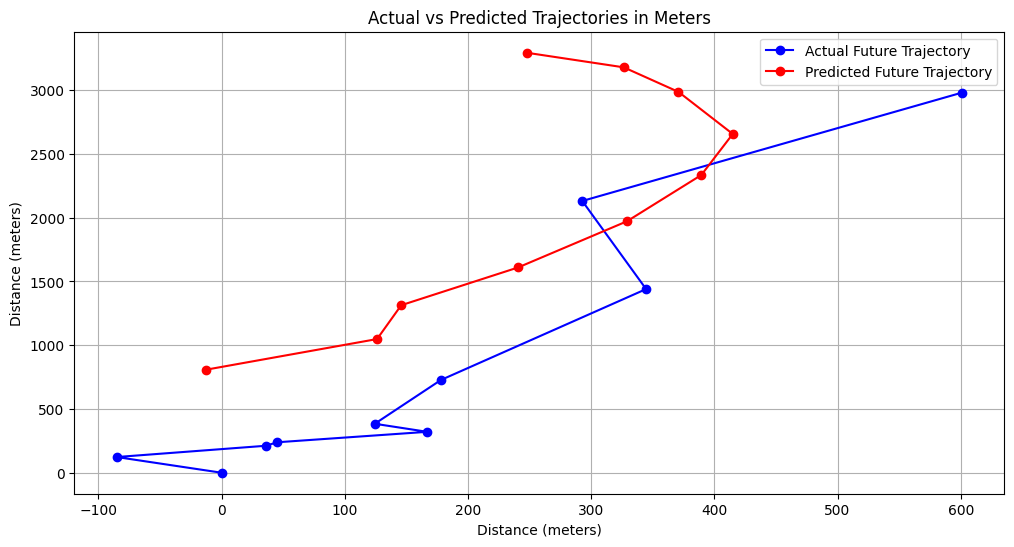

Actual_Lat | Actual_Lon |   Pred_Lat |   Pred_Lon |  Actual_X(m) |    Pred_X(m) |  Diff_X(m) |  Actual_Y(m) |    Pred_Y(m) |  Diff_Y(m)
----------------------------------------------------------------------------------------------------------------------------------
-12.895350 |  33.297722 | -12.888085 |  33.297607 |         0.00 |       -12.59 |      12.59 |         0.00 |       807.80 |    -807.80
-12.894244 |  33.296936 | -12.885924 |  33.298885 |       -85.14 |       126.23 |    -211.36 |       123.04 |      1048.09 |    -925.05
-12.893450 |  33.298054 | -12.883539 |  33.299068 |        35.91 |       145.84 |    -109.94 |       211.33 |      1313.33 |   -1102.01
-12.893203 |  33.298138 | -12.880878 |  33.299942 |        45.16 |       240.61 |    -195.45 |       238.76 |      1609.15 |   -1370.39
-12.892467 |  33.299263 | -12.877620 |  33.300758 |       166.94 |       329.08 |    -162.13 |       320.69 |      1971.52 |   -1650.83
-12.891898 |  33.298870 | -12.874359 |  33.301315 |  

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point

# Define the Earth's radius
R = 6371000  # Earth radius in meters

# Function to convert latitude and longitude to x and y coordinates in meters
def lat_lon_to_xy(lat, lon, ref_lat, ref_lon):
    lat, lon, ref_lat, ref_lon = map(np.radians, [lat, lon, ref_lat, ref_lon])
    dlon = lon - ref_lon
    dlat = lat - ref_lat
    x = R * dlon * np.cos(ref_lat)
    y = R * dlat
    return x, y

# Function to convert a trajectory to meters
def convert_trajectory_to_meters(trajectory, ref_lat, ref_lon):
    x_meters, y_meters = [], []
    for lat, lon in trajectory:
        x, y = lat_lon_to_xy(lat, lon, ref_lat, ref_lon)
        x_meters.append(x)
        y_meters.append(y)
    return np.array(x_meters), np.array(y_meters)

# Evaluation function
def evaluate_model(model, test_loader, device, scaler):
    model.load_state_dict(torch.load('Transformer_seq20.pth'))
    model.to(device)
    model.eval()

    all_actuals = []
    all_predictions = []
    all_actuals_meters = []
    all_predictions_meters = []
    rmses = []
    rmses_meters = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            predictions = predictions.view(-1, 10, 2).cpu().numpy()
            actuals = y_batch.view(-1, 10, 2).cpu().numpy()

            # Inverse transform to original scale
            predictions = scaler.inverse_transform(predictions.reshape(-1, 2)).reshape(-1, 10, 2)
            actuals = scaler.inverse_transform(actuals.reshape(-1, 2)).reshape(-1, 10, 2)

            # Convert to meters using the first point of the actual trajectory as the reference
            ref_lat, ref_lon = actuals[0][0]
            predictions_meters = [convert_trajectory_to_meters(pred, ref_lat, ref_lon) for pred in predictions]
            actuals_meters = [convert_trajectory_to_meters(act, ref_lat, ref_lon) for act in actuals]

            all_actuals.append(actuals)
            all_predictions.append(predictions)
            all_actuals_meters.append(actuals_meters)
            all_predictions_meters.append(predictions_meters)

            # Calculate RMSE for this batch and append
            batch_rmse = np.sqrt(mean_squared_error(predictions.reshape(-1, 2), actuals.reshape(-1, 2)))
            rmses.append(batch_rmse)

            batch_rmse_meters = np.sqrt(mean_squared_error(np.vstack(predictions_meters).reshape(-1, 2), np.vstack(actuals_meters).reshape(-1, 2)))
            rmses_meters.append(batch_rmse_meters)

    average_rmse = np.mean(rmses)
    average_rmse_meters = np.mean(rmses_meters)

    # Ensure shapes are consistent for printing
    all_actuals = np.vstack(all_actuals)
    all_predictions = np.vstack(all_predictions)
    all_actuals_meters = np.vstack(all_actuals_meters)
    all_predictions_meters = np.vstack(all_predictions_meters)

    return all_actuals, all_predictions, all_actuals_meters, all_predictions_meters, rmses, rmses_meters, average_rmse, average_rmse_meters

# Plotting function
def plot_trajectories_in_meters(actuals_meters, predictions_meters, index=0):
    actual_x, actual_y = actuals_meters[index]
    pred_x, pred_y = predictions_meters[index]

    plt.figure(figsize=(12, 6))
    plt.plot(actual_x, actual_y, 'bo-', label='Actual Future Trajectory')
    plt.plot(pred_x, pred_y, 'ro-', label='Predicted Future Trajectory')
    plt.xlabel('Distance (meters)')
    plt.ylabel('Distance (meters)')
    plt.title('Actual vs Predicted Trajectories in Meters')
    plt.legend()
    plt.grid(True)
    plt.show()

# Print trajectories in meters
def print_trajectories_in_meters(actuals, predictions, actuals_meters, predictions_meters, index=0):
    actual_lat_lon = actuals[index].reshape(-1, 2)
    predicted_lat_lon = predictions[index].reshape(-1, 2)

    actual_x, actual_y = actuals_meters[index][0], actuals_meters[index][1]
    pred_x, pred_y = predictions_meters[index][0], predictions_meters[index][1]

    diff_x = actual_x - pred_x
    diff_y = actual_y - pred_y

    actual_vs_predicted = np.column_stack((actual_lat_lon, predicted_lat_lon, actual_x, pred_x, diff_x, actual_y, pred_y, diff_y))

    print(f"{'Actual_Lat':>10} | {'Actual_Lon':>10} | {'Pred_Lat':>10} | {'Pred_Lon':>10} | {'Actual_X(m)':>12} | {'Pred_X(m)':>12} | {'Diff_X(m)':>10} | {'Actual_Y(m)':>12} | {'Pred_Y(m)':>12} | {'Diff_Y(m)':>10}")
    print("-" * 130)

    for row in actual_vs_predicted:
        print(f"{row[0]:>10.6f} | {row[1]:>10.6f} | {row[2]:>10.6f} | {row[3]:>10.6f} | {row[4]:>12.2f} | {row[5]:>12.2f} | {row[6]:>10.2f} | {row[7]:>12.2f} | {row[8]:>12.2f} | {row[9]:>10.2f}")


# Assuming you have the DataLoader, model, and scaler ready
all_actuals, all_predictions, all_actuals_meters, all_predictions_meters, rmses, rmses_meters, average_rmse, average_rmse_meters = evaluate_model(model, test_loader, device='cuda', scaler=scaler)

# Plot trajectories in meters
plot_trajectories_in_meters(all_actuals_meters, all_predictions_meters, index=0)

# Print trajectories in meters
print_trajectories_in_meters(all_actuals, all_predictions, all_actuals_meters, all_predictions_meters, index=0)



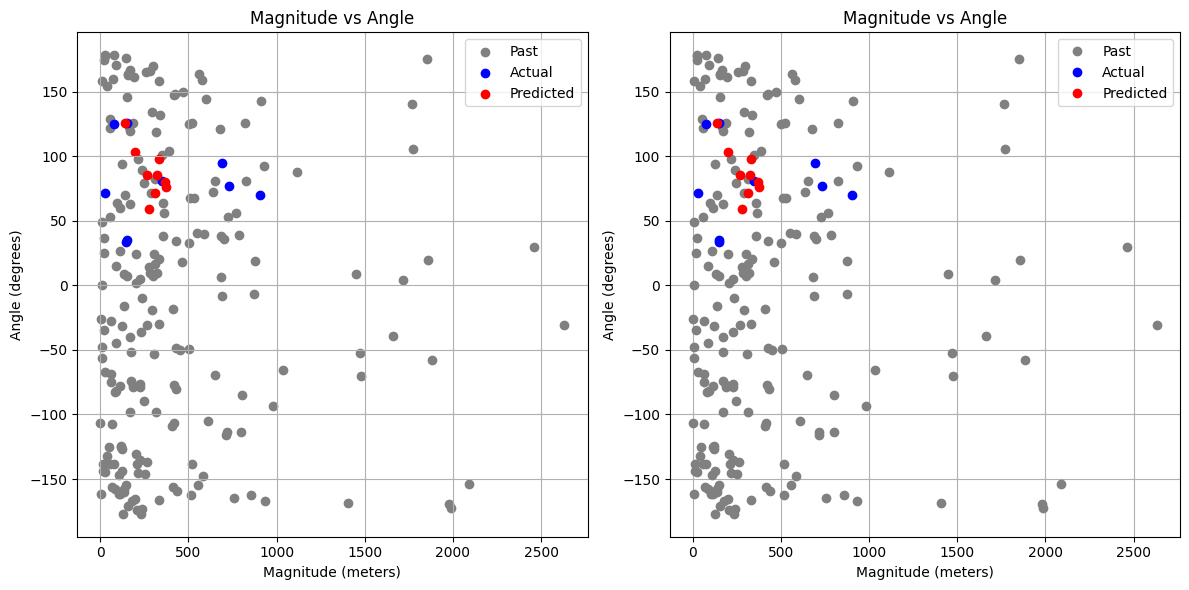

Actual Mag (m)  Pred Mag (m)    Actual Ang      Pred Ang       
------------------------------------------------------------
149.621757      277.361447      125.387889      59.402039      
149.933891      265.957035      35.403343       85.610056      
28.932541       310.645746      71.233867       71.824200      
146.902610      373.000049      33.194211       75.936144      
76.212183       367.555641      124.655146      80.306844      
347.446822      322.968021      80.873832       85.330086      
732.044461      332.856034      76.514586       97.833369      
692.731071      197.696605      94.424264       103.254586     
904.190393      139.121703      69.579608       125.275874     


In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Haversine formula to calculate the distance between two lat/lon points in meters
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # Earth radius in meters
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2.0)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    meters = R * c  # Output distance in meters
    return meters

# Function to calculate magnitude (distance in meters) and angle from lat, lon coordinates
def calculate_magnitude_angle(lat_diff, lon_diff, lat1, lon1, lat2, lon2):
    magnitude = haversine(lat1, lon1, lat2, lon2)
    angle = np.arctan2(lat_diff, lon_diff) * 180 / np.pi  # Convert radians to degrees
    return magnitude, angle

# Function to calculate magnitudes and angles for a trajectory
def trajectory_magnitude_angle(trajectory):
    lat_diff = np.diff(trajectory[:, 0])
    lon_diff = np.diff(trajectory[:, 1])
    magnitudes = []
    angles = []
    for i in range(len(lat_diff)):
        mag, ang = calculate_magnitude_angle(lat_diff[i], lon_diff[i], trajectory[i, 0], trajectory[i, 1], trajectory[i+1, 0], trajectory[i+1, 1])
        magnitudes.append(mag)
        angles.append(ang)
    return np.array(magnitudes), np.array(angles)

# Function to plot magnitude vs angle
def plot_magnitude_angle(past_data, actuals, predictions, index=0):
    past_trajectory = past_data[index]
    actual_trajectory = actuals[index].reshape(-1, 2)
    predicted_trajectory = predictions[index].reshape(-1, 2)

    past_magnitudes, past_angles = trajectory_magnitude_angle(past_trajectory)
    actual_magnitudes, actual_angles = trajectory_magnitude_angle(actual_trajectory)
    pred_magnitudes, pred_angles = trajectory_magnitude_angle(predicted_trajectory)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.scatter(past_magnitudes, past_angles, label='Past', color='gray', marker='o')
    plt.scatter(actual_magnitudes, actual_angles, label='Actual', color='blue', marker='o')
    plt.scatter(pred_magnitudes, pred_angles, label='Predicted', color='red', marker='o')
    plt.title('Magnitude vs Angle')
    plt.xlabel('Magnitude (meters)')
    plt.ylabel('Angle (degrees)')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(past_magnitudes, past_angles, label='Past', color='gray', marker='o', linestyle='None')
    plt.plot(actual_magnitudes, actual_angles, label='Actual', color='blue', marker='o', linestyle='None')
    plt.plot(pred_magnitudes, pred_angles, label='Predicted', color='red', marker='o', linestyle='None')
    plt.title('Magnitude vs Angle')
    plt.xlabel('Magnitude (meters)')
    plt.ylabel('Angle (degrees)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Print magnitudes and angles with headers
    print("{:<15} {:<15} {:<15} {:<15}".format("Actual Mag (m)", "Pred Mag (m)", "Actual Ang", "Pred Ang"))
    print("-" * 60)
    for actual_mag, pred_mag, actual_ang, pred_ang in zip(actual_magnitudes, pred_magnitudes, actual_angles, pred_angles):
        print("{:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f}".format(actual_mag, pred_mag, actual_ang, pred_ang))

# Updated evaluation function
def evaluate_model(model, test_loader, device, scaler):
    model.load_state_dict(torch.load('Transformer_seq20.pth'))
    model.to(device)
    model.eval()

    all_actuals = []
    all_predictions = []
    rmses = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            predictions = predictions.view(-1, 10, 2).cpu().numpy()
            actuals = y_batch.view(-1, 10, 2).cpu().numpy()

            # Inverse transform to original scale
            predictions = scaler.inverse_transform(predictions.reshape(-1, 2)).reshape(-1, 10, 2)
            actuals = scaler.inverse_transform(actuals.reshape(-1, 2)).reshape(-1, 10, 2)

            all_actuals.append(actuals)
            all_predictions.append(predictions)

            # Calculate RMSE for this batch and append
            batch_rmse = np.sqrt(mean_squared_error(predictions.reshape(-1, 2), actuals.reshape(-1, 2)))
            rmses.append(batch_rmse)

    average_rmse = np.mean(rmses)

    all_actuals = np.vstack(all_actuals)
    all_predictions = np.vstack(all_predictions)

    return all_actuals, all_predictions, rmses, average_rmse

# Assume other previous code and functions are defined above

# Call evaluate_model to get the results
all_actuals, all_predictions, rmses, average_rmse = evaluate_model(model, test_loader, device='cuda', scaler=scaler)

# Plot magnitude vs angle
plot_magnitude_angle(X_test, all_actuals, all_predictions, index=0)
